In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S
from holotomocupy.tomo import R, RT
from holotomocupy.chunking import gpu_batch
import holotomocupy.chunking as chunking
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import linear, dai_yuan
import sys

chunking.global_chunk = 64
%matplotlib inline
# !jupyter nbconvert --to script rec_reprojection_codes.ipynb

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension

ntheta = 720  # number of angles (rotations)
noise = 0
z1c = -19.5e-3

center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles
npos = 1  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True



flg = f'{n}_{z1c}'
flg0 = f'{2048}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'



## Read data

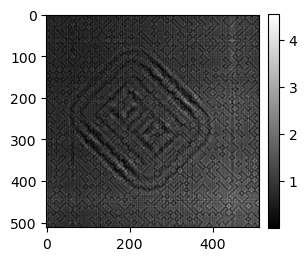

In [3]:
data = np.zeros([ntheta, npos, n, n], dtype='float32')
ref = np.zeros([1, npos, n, n], dtype='float32')
for k in range(npos):
    data[:, k] = read_tiff(f'{path}/data_3d_{k}_{flg}.tiff')[:ntheta]
for k in range(npos):
    ref[:, k] = read_tiff(f'{path}/ref_3d_{k}_{flg}.tiff')[:]

# data = cp.array(data)
# ref = cp.array(ref)
shifts_code = np.load(f'{path}/shifts_code_3d_{flg}.npy')
mshow(data[0,0],show)


(1, 2560, 2560)


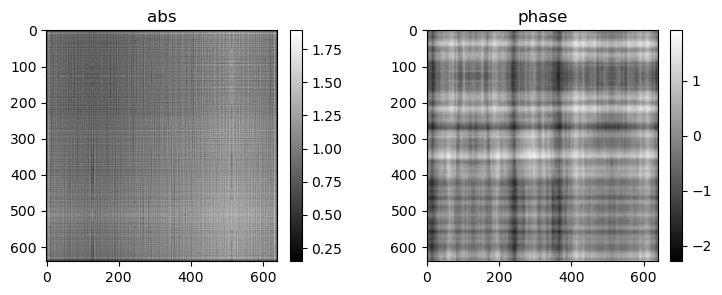

In [4]:
prb = np.load(f'{path}/prb_{flg0}.npy')
print(prb.shape)
for k in range(np.int32(np.log2(2048//n))):
    prb = 0.5*(prb[:,::2]+prb[:,1::2])
    prb = 0.5*(prb[:,:,::2]+prb[:,:,1::2])
mshow_polar(prb[0],show)

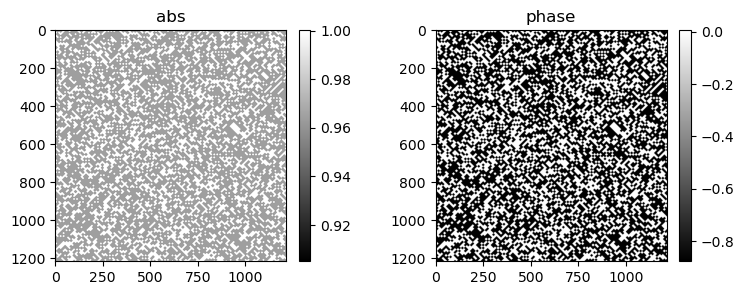

In [5]:
code = np.load(f'{path}/code_{flg0}.npy')
for k in range(np.int32(np.log2(2048//n))):
    code = 0.5*(code[:,::2]+code[:,1::2])
    code = 0.5*(code[:,:,::2]+code[:,:,1::2])
mshow_polar(code[0],show)

# Construct operators


In [6]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    #print(psi.shape)
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        
        # shift and crop the code 
        coder = S(coder, shifts_code[:, i])
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]
        # multiply by the probe
        coder *= prbr

        # propagate both to the sample plane
        coder = G(coder, wavelength, voxelsize, distances2[i])
        
        # multiply by the sample
        psir *= coder           

        # propagate all to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])

        # unpad
        data[:, i] = psir[:, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2]
        
    return data

@gpu_batch
def _adj_holo(data, shifts_code, prb, code):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        prbr = cp.tile(prb,[psi.shape[0],1,1])        
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        psir = GT(psir, wavelength, voxelsize, distances[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]        
        coder *= prbr
        coder = G(coder, wavelength, voxelsize, distances2[j])
        psir *= cp.conj(coder)
        psi += psir
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi, code):
    psi = cp.array(psi)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = psi.copy()
        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        prbr*=cp.conj(psir)
        prbr = GT(prbr, wavelength, voxelsize, distances2[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]
        prbr *= cp.conj(coder)
        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb, code)
def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''
    return np.sum(_adj_holo_prb(data, shifts_code, psi, code), axis=0)[np.newaxis]

# adjoint tests
tmp = data.copy()
arr1 = np.pad(np.array(tmp[:, 0]+1j*tmp[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')

prb1 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
print(f'{np.sum(prb1*np.conj(arr4))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = arr1.swapaxes(0,1)
a = RT(arr1,theta,ne//2)
b = R(a,theta,ne//2)
c = RT(b,theta,ne//2)
print(f'{np.sum(arr1*np.conj(b))}==\n{np.sum(a*np.conj(a))}')
print(f'{np.sum(a*np.conj(a))}==\n{np.sum(a*np.conj(c))}')

(372637216+4019677.25j)==
(462193120-0.00027896181563846767j)
(462194112-6.5654296875j)==
(462193120-0.00027896181563846767j)
(614669824+65.2614974975586j)==
(614672384-0.001951519283466041j)
(614672384-0.001951519283466041j)==
(616363776-78.25615692138672j)


### Propagate the code to the detector and divide all data by it

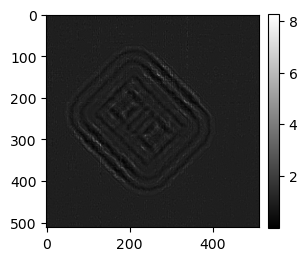

In [7]:
psi1 = np.ones([ntheta,ne,ne],dtype='complex64')
prb1 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
d = np.abs(fwd_holo(psi1,prb1))**2

rdata = data/d/ref
mshow((rdata)[0,0],show)

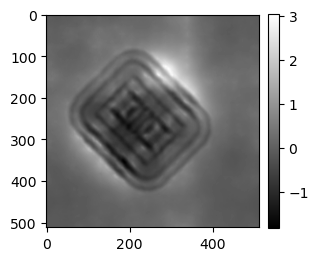

In [8]:
# distances should not be normalized
distances_pag = (distances)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  100, 1e-2))
mshow(np.angle(recMultiPaganin[0]),show)

#### Exponential and logarithm functions for the Transmittance function

In [9]:
def exptomo(psi):
    """Exp representation of projections"""
    return np.exp(1j*psi * voxelsize * 2*cp.pi / wavelength*np.sqrt(ne*ntheta))
    
def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    res = -1j * wavelength / (2*cp.pi) * res / voxelsize/np.sqrt(ne*ntheta)
    return res

# Operators for the flat field

In [10]:
def _fwd_holo0(prb):
    data = cp.zeros([1, npos, n, n], dtype='complex64')
    prb = cp.array(prb)
    for j in range(npos):
        # propagate illumination
        data[:, j] = G(prb, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data.get()

def fwd_holo0(prb):
    return _fwd_holo0(prb)

def _adj_holo0(data):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    data =cp.array(data)
    for j in range(npos):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += prbr
    return prb.get()

def adj_holo0(data):
    return _adj_holo0(data)


# adjoint test
tmp = data[0, :].copy()
prb1 = np.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = np.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)


print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(645336.1875+0.00472259521484375j)==
(645336.25+8.965766028268263e-06j)


In [11]:
def redot(a,b):
    return np.sum(a.real*b.real+a.imag*b.imag)

In [12]:
def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional    
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = cp.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    center_pad = u.shape[-1]//2
    for i in range(pars['titer']):
        fu = R(u,theta,center_pad)
        grad = 2*RT(fu-data,theta,center_pad)
        if i == 0:
            eta = -grad
        else:
            top = 2*redot(RT(R(grad,theta,center_pad),theta,center_pad),eta)
            bottom = 2*redot(RT(R(eta,theta,center_pad),theta,center_pad),eta)
            beta = top/bottom
            eta = -grad+beta*eta
        top = -redot(grad,eta)
        bottom = 2*redot(RT(R(eta,theta,center_pad),theta,center_pad),eta)
        alpha = top/bottom
        u +=alpha*eta
        print(i,alpha,minf(R(u,theta,center_pad)))
    return u


In [13]:
psirec = np.pad(np.array(recMultiPaganin),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')

#tomo initial guess
xi = 1/1j*np.log(psirec).swapaxes(0,1)

urec0 = np.zeros([ne,ne,ne],dtype='complex64')
pars = {'titer':8, 'gammau':0.5}
urec0 = cg_tomo(xi,urec0,pars)
mshow_complex(urec0[:,ne//2,:],show)

0 0.6237505620667543 18027352.0
1 1.6854034578632908 8203246.0
2 2.955606200334667 5391769.0
3 4.807857774825829 4302015.5
4 2.8367365700714715 3863696.5
5 5.417639585656258 3429975.2


0), float(alpha)=1.0589231426967647 err=1.90918e+05


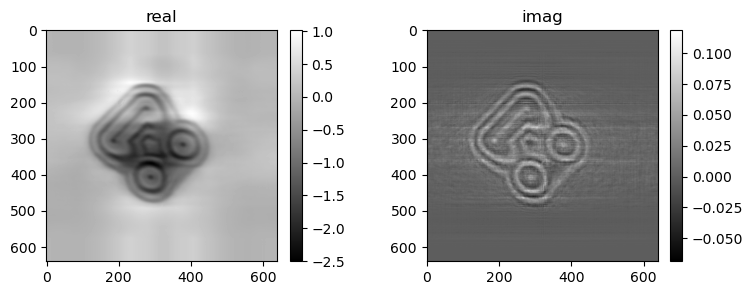

1), float(alpha)=3.787333032083878 err=1.57925e+05
2), float(alpha)=1.479329854642717 err=1.23041e+05
3), float(alpha)=1.8464870937776303 err=9.55204e+04
4), float(alpha)=1.6143134718071093 err=7.25918e+04
5), float(alpha)=1.3722463987277171 err=6.07421e+04
6), float(alpha)=1.7445228235227348 err=5.07463e+04
7), float(alpha)=1.6007410203760224 err=4.28498e+04
8), float(alpha)=1.8475071949301427 err=3.70904e+04
9), float(alpha)=1.9564670041684447 err=3.13986e+04
10), float(alpha)=1.6492999206371863 err=2.77859e+04
11), float(alpha)=2.003181174133684 err=2.41458e+04
12), float(alpha)=1.7204234787283104 err=2.16335e+04
13), float(alpha)=1.843920088470519 err=1.95749e+04
14), float(alpha)=1.4416999326570528 err=1.78464e+04
15), float(alpha)=1.90405527264768 err=1.64037e+04


In [ ]:

def hessian2(Lpsi,Lpsi1,Lpsi2,data):
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = redot(1-d0,np.real(Lpsi1*np.conj(Lpsi2)))
    v2 = redot(d0,np.real(np.conj(l0)*Lpsi1)*np.real(np.conj(l0)*Lpsi2))
    return 2*(v1+v2)

def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f
    
def cg(data, init_u, prb, pars):

    data = np.sqrt(data)
    u = init_u.copy()    

    conv = np.zeros(pars['niter'])
    alphaa = np.zeros(pars['niter'])    
    center_pad = u.shape[-1]//2
    for i in range(pars['niter']):
        
        # \nabla(F)_X
        eR = np.exp(1j*R(u,theta,center_pad).swapaxes(0,1))
        Lpsi = fwd_holo(eR,prb)        
        gradF = 2*adj_holo(Lpsi-data*np.exp(1j*np.angle(Lpsi)),prb)        
               
        # \nabla(G)_U0
        grad = np.conj(eR)*gradF
        grad = -1j*RT(grad.swapaxes(0,1),theta,center_pad)                                
        
        Rgrad = R(grad,theta,center_pad).swapaxes(0,1)
        
        if i == 0:
            eta = -grad            
            Reta = -Rgrad
        else:                     
            Lpsi = fwd_holo(eR,prb)
            Lgrad = fwd_holo(eR*(1j*Rgrad),prb)
            Leta = fwd_holo(eR*(1j*Reta),prb)

            top = redot(gradF,eR*(1j*Rgrad)*(1j*Reta))
            top += hessian2(Lpsi,Lgrad,Leta,data)

            bottom = redot(gradF,eR*(1j*Reta)*(1j*Reta))
            bottom += hessian2(Lpsi,Leta,Leta,data)

            beta = top/bottom
            
            eta = -grad + beta*eta
            Reta = -Rgrad + beta*Reta  

        
        top = -redot(grad,eta)      
        bottom = redot(gradF,eR*(1j*Reta)**2)

        Lpsi = fwd_holo(eR,prb)
        Leta = fwd_holo(eR*(1j*Reta),prb)     
        bottom += hessian2(Lpsi,Leta,Leta,data)
                
        alpha = top/bottom
        u += alpha*eta
        
        if i % pars['err_step'] == 0:
            eR = np.exp(1j*R(u,theta,u.shape[-1]//2).swapaxes(0,1))
            Lpsi = fwd_holo(eR,prb)
            err = minf(Lpsi,data)
            conv[i] = err
            alphaa[i] = alpha
            print(f'{i}), {float(alpha)=} {err=:1.5e}')

        if i % pars['vis_step'] == 0 and pars['vis_step'] > -1 :
            mshow_complex(u[:,ne//2+3,:],show)            
            
    return u,conv,alphaa

urec = urec0.copy()
rec_prb = prb.copy()
pars = {'niter': 513, 'err_step': 1, 'vis_step': 16}

urec,conv,step = cg(data, urec,rec_prb, pars)

